In [1]:
!rm -r Neural_Networks-101-demo
!git clone https://github.com/KiranArun/Neural_Networks-101-demo.git
!python3 /content/Neural_Networks-101-demo/scripts/setup.py pytorch

Cloning into 'Neural_Networks-101-demo'...
remote: Counting objects: 176, done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 176 (delta 76), reused 132 (delta 41), pack-reused 0
Receiving objects: 100% (176/176), 1.44 MiB | 22.07 MiB/s, done.
Resolving deltas: 100% (76/76), done.
Installing Pytorch...


# MNIST Handwriten Digits Classifier

In [0]:
# import libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as utils

import numpy as np
import matplotlib.pyplot as plt
from math import ceil

In [3]:
# this is the directory where we will keep and external files, eg. data, logs
model_root_dir = '/content/Neural_Networks-101-demo/'

# get data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(model_root_dir+'MNIST_data', one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /content/Neural_Networks-demo/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /content/Neural_Networks-demo/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /content/Neural_Networks-demo/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /content/Neural_Networks-demo/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
# Hyperparams
image_size = 28
num_classes = 10

batch_size = 100
learning_rate = 0.2
dropout_rate = 0.4

epochs = 2

if torch.cuda.is_available():
  dtype = torch.cuda.FloatTensor
  long_dtype = torch.cuda.LongTensor
else:
  dtype = torch.FloatTensor
  long_dtype = torch.LongTensor

In [0]:
# create pytorch dataset with mnist data
training_dataset = utils.TensorDataset(torch.Tensor(mnist.train.images),torch.LongTensor(mnist.train.labels))

# create pytorch dataloader for extra features and ease of use in training loop
training_loader = utils.DataLoader(dataset=training_dataset,
                                   batch_size=batch_size,
                                   shuffle=True)

In [0]:
# define NN
class Net(nn.Module):
    
    def __init__(self, num_classes):
        super(Net, self).__init__()
        
        # define convolutional layers 1 and 2
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=8,kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=5)
        
        # define fc layers 1 and 2, with 2 being the output layer
        self.fc1 = nn.Linear(16*4*4, 256)
        self.fc2 = nn.Linear(256, num_classes)
    
    # define forward pass
    def forward(self, x):
        
        x = x.view(-1,1,image_size,image_size)
        
        # apply conv1 and relu
        x = F.relu(self.conv1(x))
        # apply max pooling
        x = F.max_pool2d(input=x,kernel_size=(2,2),stride=2)
        
        # apply conv2 and relu
        x = F.relu(self.conv2(x))
        # apply max pooling
        x = F.max_pool2d(input=x,kernel_size=(2,2),stride=2)
        
        # flatten
        x = x.view(-1,16*4*4)
        
        # fc layer 1
        x = F.relu(self.fc1(x))
        # apply dropout to fc1
        x = F.dropout(input=x,p=dropout_rate,training=self.training)
        
        # output layer, with a fc
        out = self.fc2(x)
        
        return out

In [0]:
# set net to our Net with params
net = Net(num_classes)

# define loss function
loss_func = nn.CrossEntropyLoss() 
# define optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

if torch.cuda.is_available():
  net.cuda()
  loss_func.cuda()

In [0]:
# create function to calculate accuracy
def get_accuracy(images,labels):
    
    test_x = Variable(torch.Tensor(images)).type(dtype)
    test_y = torch.LongTensor(labels).type(long_dtype)

    _outputs = net(test_x)
    _, _predicted = torch.max(_outputs.data, 1)
    
    num_correct = (_predicted.cpu() == test_y).sum()
    num_total = test_y.size(0)

    return(str(100.0 * num_correct/num_total)+'%')

In [9]:
# calculate iterations to print as total steps
iterations = int(ceil(training_loader.dataset.target_tensor.size()[0]/float(batch_size)))

# initialize losses array
losses = np.array([])

for epoch in range(epochs):
    
    print('New epoch', str(epoch+1)+'/'+str(epochs))
    
    # for each batch in data loader
    for idx, (images, labels) in enumerate(training_loader):
        
        # set images and labels to variables so we can calculate the gradient
        images = Variable(images).type(dtype)
        labels = Variable(labels).type(long_dtype)

        # reset the parameter gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = net(images)
        # calculate loss
        loss = loss_func(outputs, labels)
        # calculate parameter gradients
        loss.backward()
        # update weights
        optimizer.step()

        if (idx+1) % 50 == 0:
            # set to evaluating mode, to avoid dropout
            net.eval()
            # calculate validation accuracy
            _accuracy = get_accuracy(mnist.validation.images, mnist.validation.labels)
            # print current status
            print('step', str(idx+1)+'/'+str(iterations), 'loss', loss.data[0], 'accuracy', _accuracy)
            
            # set back to training mode
            net.train()
            
        # append current loss to losses array to plot
        losses = np.append(losses, loss.data[0])

New epoch 1/2
step 50/550 loss 0.6854215860366821 accuracy 73.5%
step 100/550 loss 0.38168948888778687 accuracy 92.8%
step 150/550 loss 0.17856808006763458 accuracy 94.84%
step 200/550 loss 0.1025632917881012 accuracy 95.92%
step 250/550 loss 0.2608269453048706 accuracy 96.48%
step 300/550 loss 0.26611146330833435 accuracy 96.66%
step 350/550 loss 0.14445386826992035 accuracy 95.74%
step 400/550 loss 0.14748118817806244 accuracy 97.32%
step 450/550 loss 0.05167602375149727 accuracy 97.4%
step 500/550 loss 0.1569683700799942 accuracy 97.38%
step 550/550 loss 0.09991662949323654 accuracy 97.8%
New epoch 2/2
step 50/550 loss 0.11706279963254929 accuracy 97.92%
step 100/550 loss 0.05993209779262543 accuracy 97.78%
step 150/550 loss 0.07681483030319214 accuracy 98.08%
step 200/550 loss 0.05821235477924347 accuracy 97.72%
step 250/550 loss 0.03982855752110481 accuracy 98.1%
step 300/550 loss 0.0146331200376153 accuracy 97.84%
step 350/550 loss 0.019829755648970604 accuracy 98.06%
step 400/55

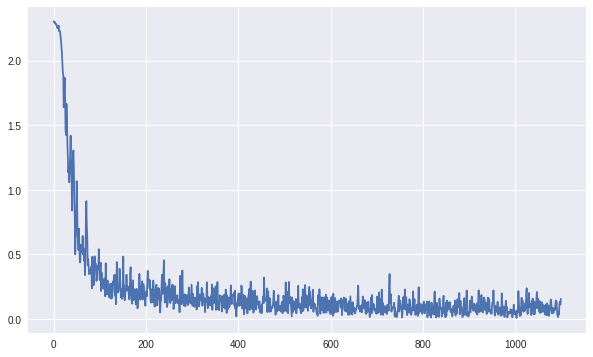

In [10]:
# plot losses
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(losses)
ax.grid(True)

In [13]:
# show evaluation accuracy
net.eval()
print(get_accuracy(mnist.test.images,mnist.test.labels))

98.45%


prediction: 2 answer: 2
0 0.01%
1 0.01%
2 99.98%
3 0.0%
4 0.0%
5 0.0%
6 0.0%
7 0.0%
8 0.01%
9 0.0%


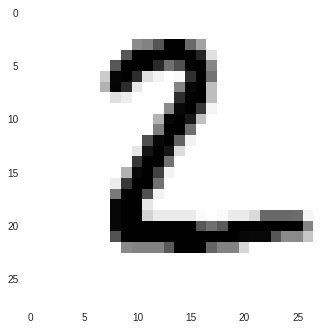

prediction: 6 answer: 6
0 0.56%
1 0.0%
2 0.0%
3 0.0%
4 0.0%
5 0.1%
6 99.19%
7 0.0%
8 0.14%
9 0.0%


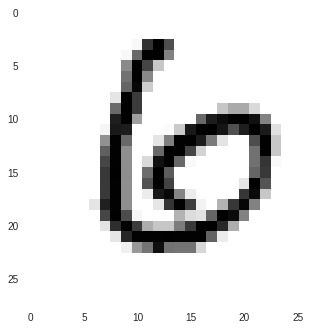

In [12]:
# test and show test images
test_idxs = [1,11]

for test_idx in test_idxs:
    test_x = Variable(torch.Tensor(mnist.test.images[test_idx].reshape(1,-1))).type(dtype)
    test_y = mnist.test.labels[test_idx]

    _prediction = net(test_x)

    print('prediction:', np.argmax(_prediction.cpu().data.numpy()), 'answer:', test_y)

    for i,val in enumerate(_prediction[0]):
        print(i, str(round(float(100*np.exp(val)/np.sum(np.exp(_prediction))),2))+'%')

    plt.imshow(test_x.cpu().data.numpy().reshape(image_size,image_size), cmap='binary')
    plt.grid(False)
    plt.show()